<a href="https://colab.research.google.com/github/VishalMaurya/Deeplearning-TimeSeries/blob/main/LSTM_TimeSeries_basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using RNNs for time series forecasting
This notebook is for better understand Time Series data and how to build models/pipeline using Deep Learning (Recurrent Neural Networks) in tensorflow(keras).Keras is a high level API of tensorflow implelemntation for fast prototyping for model architcture. We will preprocess Time Series, build a simple LSTM model, train it, and use it to make predictions.

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc


import tensorflow as tf
from tensorflow import keras

In [5]:
print(tf.__version__)

2.3.0


In [27]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 7

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

 ## Creating our data
 
 We’ll start with a simple example of forecasting the values of the Sine function using a simple LSTM network.

 We’ll generate 1,000 values from the sine function with some noise and use that as our data.

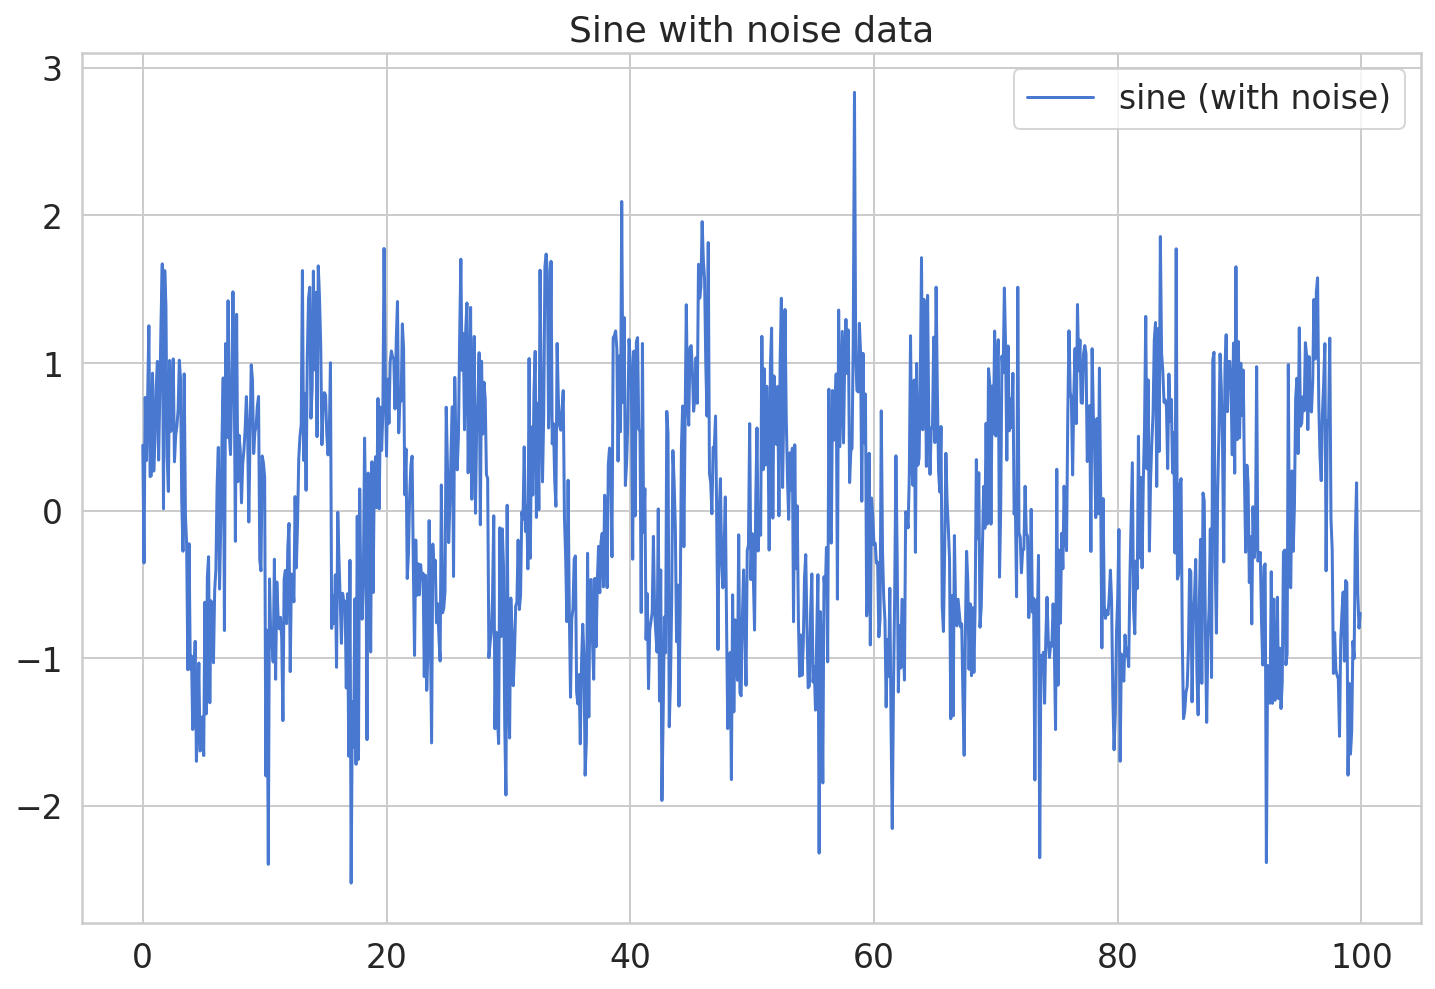

In [37]:
# generate sine function data with noise
time = np.arange(0, 100, 0.1)
sin = np.sin(time) + np.random.normal(scale=0.5, size=len(time))

# plot the sine data
plt.plot(time, sin, label='sine (with noise)')
plt.title('Sine with noise data')
plt.legend();

## Data Preprocessing

We need to apply preprocessing and transformation on our data to make it feedable to the model.

In [29]:
df = pd.DataFrame(dict(sine=sin), index=time, columns=['sine'])
df.head()

,sine
0.0,0.845263
0.1,-0.133135
0.2,0.215079
0.3,0.499278
0.4,-0.005043


In [30]:
# create dataset with given time step window
def create_dataset(X, y, time_steps = 1):    
    Xs, ys = [], []
    for i in range(X.shape[0] -  time_steps):
        Xs.append(  X.iloc[i: ( i + time_steps)].values )
        ys.append( y.iloc[i + time_steps] )
    return np.array(Xs), np.array(ys)


# split train and test data
split = 0.8

train_size = int(df.shape[0] * split)
test_size = df.shape[0] - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

800 200


In [31]:
# generate dataset
# reshape to [samples, time_steps, n_features] since LSTM accept input in 3d ( s, ts, n_feat)
time_steps = 10

X_train, y_train = create_dataset(train, train.sine, time_steps)
X_test, y_test = create_dataset(test, test.sine, time_steps)

print(X_train.shape, y_train.shape)

(790, 10, 1) (790,)


## Modeling using Keras Sequential API
We’ll use the Keras LSTM layer in a sequential model to make our predictions.

In [32]:
def create_baseline(X_train):
    model = keras.Sequential()
    model.add(keras.layers.LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(keras.layers.Dense(1))
    model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(0.001))
    return model

In [33]:
model = create_baseline(X_train)
history = model.fit(
                    X_train, y_train, 
                    epochs=30, 
                    batch_size=16, 
                    validation_split=0.2, 
                    verbose=1, 
                    shuffle=False
                    )

Epoch 1/30
40/40 [==============================] - 1s 21ms/step - loss: 0.4111 - val_loss: 0.3532
Epoch 2/30
40/40 [==============================] - 0s 12ms/step - loss: 0.3259 - val_loss: 0.3167
Epoch 3/30
40/40 [==============================] - 0s 11ms/step - loss: 0.3160 - val_loss: 0.3127
Epoch 4/30
40/40 [==============================] - 0s 10ms/step - loss: 0.3150 - val_loss: 0.3119
Epoch 5/30
40/40 [==============================] - 0s 10ms/step - loss: 0.3141 - val_loss: 0.3116
Epoch 6/30
40/40 [==============================] - 0s 9ms/step - loss: 0.3136 - val_loss: 0.3115
Epoch 7/30
40/40 [==============================] - 0s 9ms/step - loss: 0.3131 - val_loss: 0.3115
Epoch 8/30
40/40 [==============================] - 0s 11ms/step - loss: 0.3128 - val_loss: 0.3115
Epoch 9/30
40/40 [==============================] - 0s 11ms/step - loss: 0.3125 - val_loss: 0.3114
Epoch 10/30
40/40 [==============================] - 0s 11ms/step - loss: 0.3123 - val_loss: 0.3114
Epoch 11/30

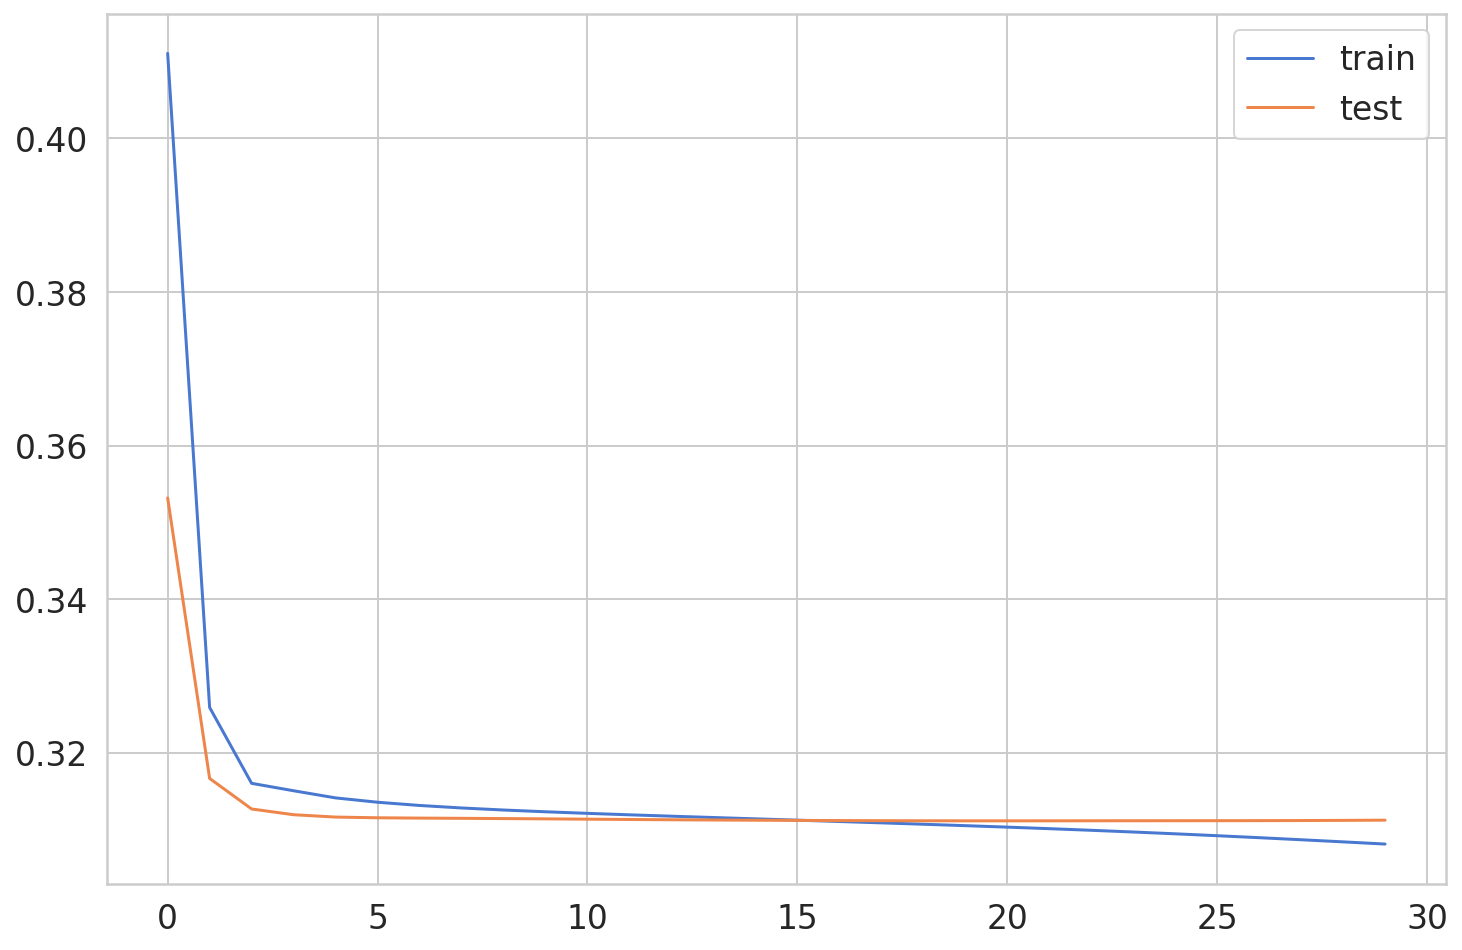

In [34]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

## Evaluation

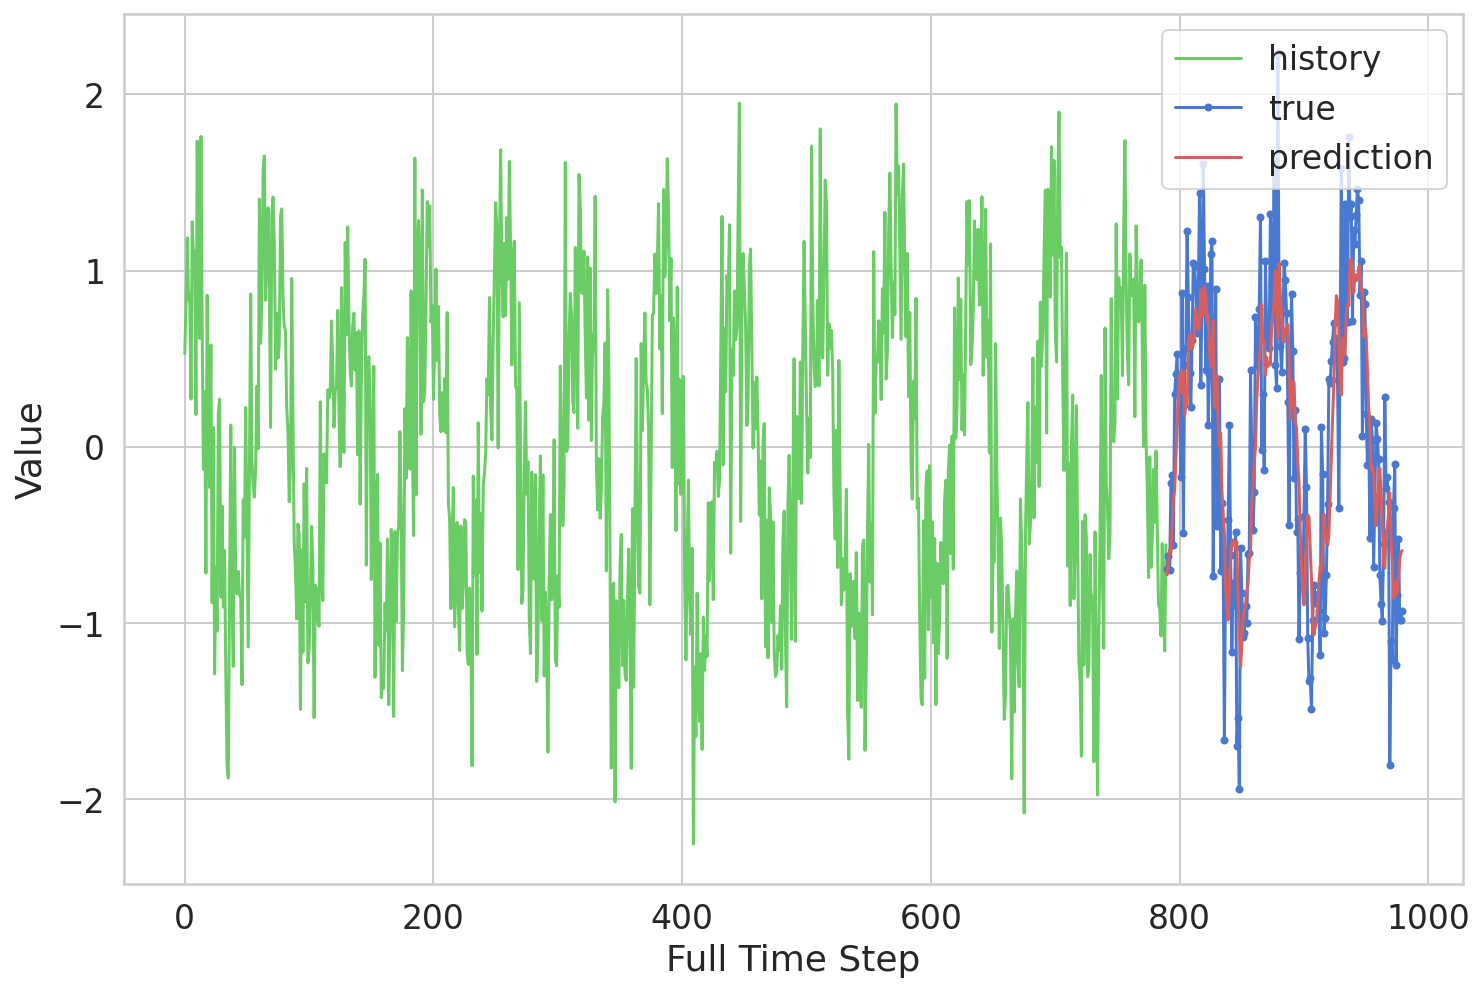

In [35]:
# evaluation of test data by showing forecasting with train data
y_pred = model.predict(X_test)

plt.plot(np.arange(0, len(y_train)), y_train[0:], 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Full Time Step')
plt.legend()
plt.show();

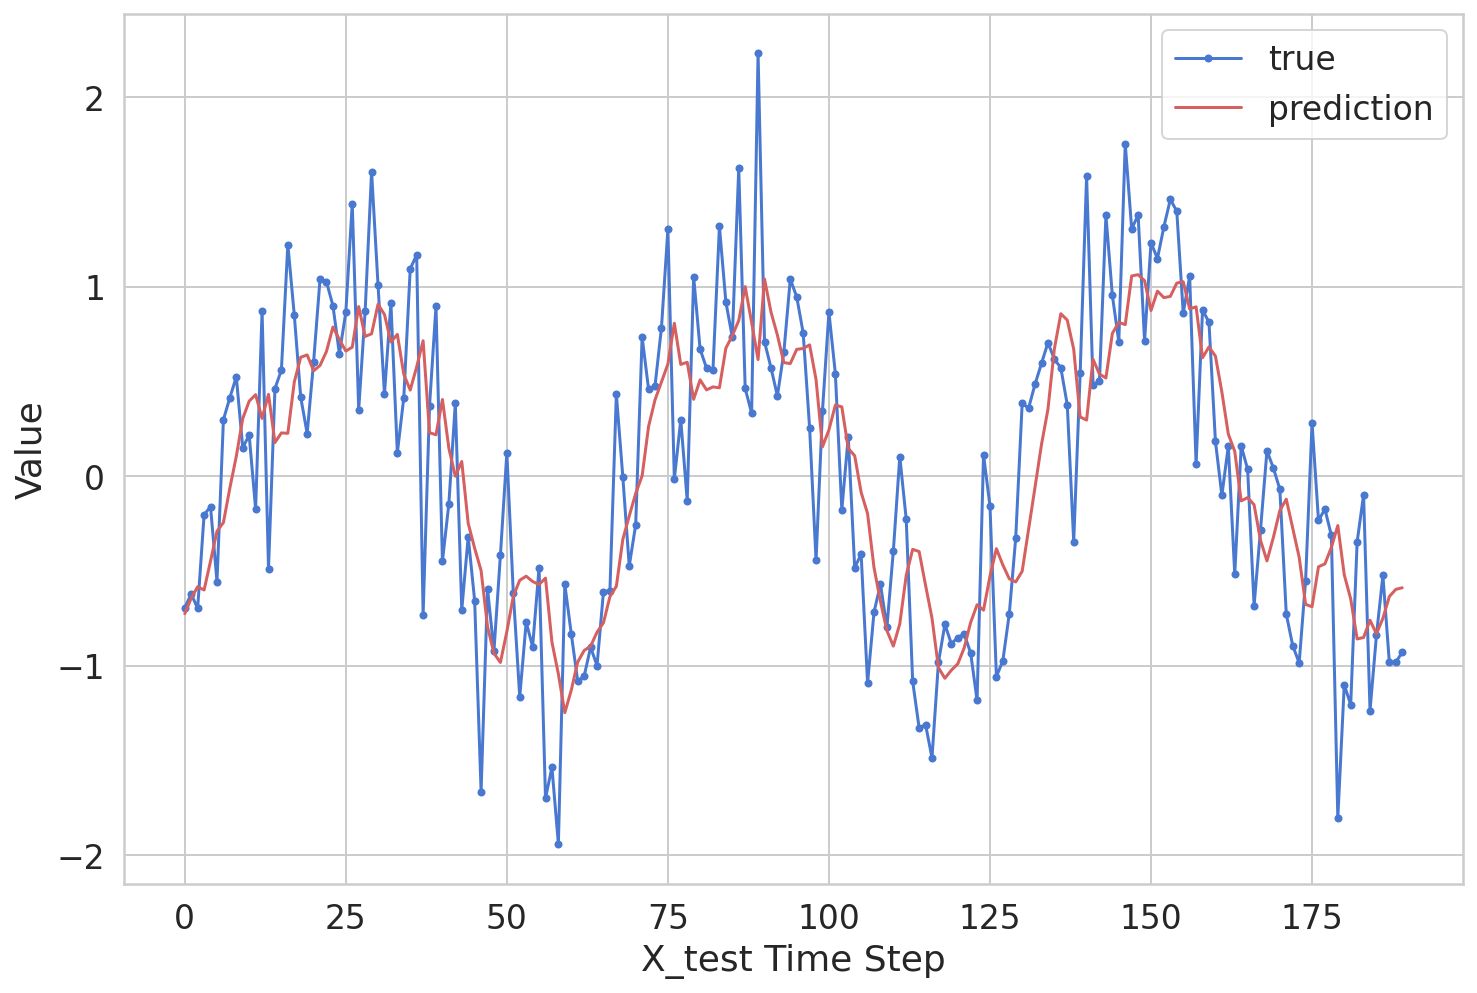

In [36]:
# evaluation of test data by showing forecasting with actual data

plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('X_test Time Step')
plt.legend()
plt.show();

The model seems to be doing a good job of capturing the general patterns. It fails to capture random fluctuations, which is a good thing (it generalizes well).